In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0624

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - loss: 0.0482
Average validation loss: 0.5813049674034119
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - loss: 0.0482 - val_loss: 0.5813
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 530ms/step - loss: 0.0346 - val_loss: 0.5813
Average validation loss: 0.4525299370288849
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 542ms/step - loss: 0.0346 - val_loss: 0.5169
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 742ms/step - loss: 0.0275 - val_loss: 0.5169
Average validation loss: 0.38910919427871704
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 757ms/step - loss: 0.0275 - val_loss: 0.4743
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segf

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 793ms/step - loss: 1.5881e-04
Average validation loss: 0.17227451503276825
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 803ms/step - loss: 1.5881e-04 - val_loss: 0.1723
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 792ms/step - loss: 1.4906e-04 - val_loss: 0.1723
Average validation loss: 0.290290504693985
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 802ms/step - loss: 1.4906e-04 - val_loss: 0.2313
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 858ms/step - loss: 1.4297e-04 - val_loss: 0.2313
Average validation loss: 0.16810652613639832
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 867ms/step - loss: 1.4297e-04 - val_loss: 0.2102
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_10.pth'.
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 844ms/step - loss: 1.3930e-04 - val_loss: 0.2102
Average

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 808ms/step - loss: 5.3640e-05
Average validation loss: 0.06501343411703904
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 819ms/step - loss: 5.3640e-05 - val_loss: 0.0650
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 821ms/step - loss: 5.2228e-05 - val_loss: 0.0650
Average validation loss: 0.0903596431016922
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 833ms/step - loss: 5.2228e-05 - val_loss: 0.0777
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 843ms/step - loss: 5.1812e-05 - val_loss: 0.0777
Average validation loss: 0.03719211556017399
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 855ms/step - loss: 5.1812e-05 - val_loss: 0.0642
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_15.pth'.
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 839ms/step - loss: 4.9626e-05 - val_los

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 848ms/step - loss: 1.6007e-05
Average validation loss: 0.17394078522920609
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 859ms/step - loss: 1.6007e-05 - val_loss: 0.1739
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 830ms/step - loss: 1.3664e-05 - val_loss: 0.1739
Average validation loss: 0.048288312973454595
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 841ms/step - loss: 1.3664e-05 - val_loss: 0.1111
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 824ms/step - loss: 1.1595e-05 - val_loss: 0.1111
Average validation loss: 0.022552509093657136
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 835ms/step - loss: 1.1595e-05 - val_loss: 0.0816
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 820ms/step - loss: 3.0616e-05
Average validation loss: 0.08304077610373498
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 833ms/step - loss: 3.0616e-05 - val_loss: 0.0830
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 819ms/step - loss: 2.4733e-05 - val_loss: 0.0830
Average validation loss: 0.0875438928604126
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 831ms/step - loss: 2.4733e-05 - val_loss: 0.0853
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 866ms/step - loss: 2.0653e-05 - val_loss: 0.0853
Average validation loss: 0.017083073034882545
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 876ms/step - loss: 2.0653e-05 - val_loss: 0.0626
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 792ms/step - loss: 1.7540e-05 - val_lo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 795ms/step - loss: 3.9114e-05
Average validation loss: 0.07836656070624788
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 805ms/step - loss: 3.9114e-05 - val_loss: 0.0784
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 2.5154e-05 - val_loss: 0.0784
Average validation loss: 0.017734490723038714
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 798ms/step - loss: 2.5154e-05 - val_loss: 0.0481
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 797ms/step - loss: 1.8841e-05 - val_loss: 0.0481
Average validation loss: 0.005335281797063847
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 806ms/step - loss: 1.8841e-05 - val_loss: 0.0338
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 804ms/step - loss: 2.2459e-05
Average validation loss: 0.11041585924103856
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 814ms/step - loss: 2.2459e-05 - val_loss: 0.1104
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 779ms/step - loss: 1.5884e-05 - val_loss: 0.1104
Average validation loss: 0.014676636690273881
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 789ms/step - loss: 1.5884e-05 - val_loss: 0.0625
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 792ms/step - loss: 1.2651e-05 - val_loss: 0.0625
Average validation loss: 0.013839593785814942
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 802ms/step - loss: 1.2651e-05 - val_loss: 0.0463
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 815ms/step - loss: 1.3506e-05
Average validation loss: 0.051073438041688256
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 827ms/step - loss: 1.3506e-05 - val_loss: 0.0511
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 814ms/step - loss: 9.1314e-06 - val_loss: 0.0511
Average validation loss: 0.01948523666942492
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 825ms/step - loss: 9.1314e-06 - val_loss: 0.0353
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 792ms/step - loss: 6.8853e-06 - val_loss: 0.0353
Average validation loss: 0.038816697003009416
48/48 ━━━━━━━━━━━━━━━━━━━━ 118s 803ms/step - loss: 6.8853e-06 - val_loss: 0.0365
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 156s 793ms/step - loss: 5.5667e-06 - v

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 789ms/step - loss: 4.8855e-06
Average validation loss: 0.07257715539474573
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 801ms/step - loss: 4.8855e-06 - val_loss: 0.0726
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 821ms/step - loss: 3.9077e-06 - val_loss: 0.0726
Average validation loss: 0.020657552372930304
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 832ms/step - loss: 3.9077e-06 - val_loss: 0.0466
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 869ms/step - loss: 3.1547e-06 - val_loss: 0.0466
Average validation loss: 0.010665869040946876
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 880ms/step - loss: 3.1547e-06 - val_loss: 0.0346
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_K

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 796ms/step - loss: 8.9180e-06
Average validation loss: 0.01834389439318329
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 807ms/step - loss: 8.9180e-06 - val_loss: 0.0183
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 801ms/step - loss: 6.1075e-06 - val_loss: 0.0183
Average validation loss: 0.016042865987401456
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 812ms/step - loss: 6.1075e-06 - val_loss: 0.0172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 797ms/step - loss: 5.4209e-06 - val_loss: 0.0172
Average validation loss: 0.02243513154098764
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 809ms/step - loss: 5.4209e-06 - val_loss: 0.0189
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 207s 799ms/step - loss: 4.5396e-06 - 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 789ms/step - loss: 2.3910e-06
Average validation loss: 0.010328408078445742
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 800ms/step - loss: 2.3910e-06 - val_loss: 0.0103
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 797ms/step - loss: 1.8993e-06 - val_loss: 0.0103
Average validation loss: 0.014089726222058138
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 808ms/step - loss: 1.8993e-06 - val_loss: 0.0122
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 790ms/step - loss: 1.6459e-06 - val_loss: 0.0122
Average validation loss: 0.010731764124809869
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 801ms/step - loss: 1.6459e-06 - val_loss: 0.0117
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 233s 824ms/step - loss: 1.4279e-06 - val_loss: 0.0117
Average validation loss: 0.011734519464274248
72/72 ━━━━━━━━━━━━━━━━━━━━ 234s 835ms/step - loss: 1.4279e-06 - val_loss: 0.0117
Epoch

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 792ms/step - loss: 2.4029e-06
Average validation loss: 0.006288228352786973
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 803ms/step - loss: 2.4029e-06 - val_loss: 0.0063
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 803ms/step - loss: 2.5605e-06 - val_loss: 0.0063
Average validation loss: 0.007266175147378817
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 814ms/step - loss: 2.5605e-06 - val_loss: 0.0068
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 813ms/step - loss: 2.0234e-06 - val_loss: 0.0068
Average validation loss: 0.005286170390900224
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 824ms/step - loss: 2.0234e-06 - val_loss: 0.0063
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_100.pth'.
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 263s 839ms/step - loss: 1.7372e-0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 792ms/step - loss: 3.8780e-06
Average validation loss: 0.024781483652380604
96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 802ms/step - loss: 3.8780e-06 - val_loss: 0.0248
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 799ms/step - loss: 2.9608e-06 - val_loss: 0.0248
Average validation loss: 0.01154216481760765
96/96 ━━━━━━━━━━━━━━━━━━━━ 155s 809ms/step - loss: 2.9608e-06 - val_loss: 0.0182
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 232s 803ms/step - loss: 2.8604e-06 - val_loss: 0.0182
Average validation loss: 0.010484473634278402
96/96 ━━━━━━━━━━━━━━━━━━━━ 233s 813ms/step - loss: 2.8604e-06 - val_loss: 0.0156
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weigh

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 801ms/step - loss: 7.9835e-06
Average validation loss: 0.01035314475884661
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 812ms/step - loss: 7.9835e-06 - val_loss: 0.0104
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 796ms/step - loss: 5.6070e-06 - val_loss: 0.0104
Average validation loss: 0.012838867279545715
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 807ms/step - loss: 5.6070e-06 - val_loss: 0.0116
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 808ms/step - loss: 4.4087e-06 - val_loss: 0.0116
Average validation loss: 0.00838229248377805
120/120 ━━━━━━━━━━━━━━━━━━━━ 293s 820ms/step - loss: 4.4087e-06 - val_loss: 0.0105
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 389s 802ms/step - los

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 811ms/step - loss: 9.6773e-06
Average validation loss: 0.012957315465124944
144/144 ━━━━━━━━━━━━━━━━━━━━ 118s 822ms/step - loss: 9.6773e-06 - val_loss: 0.0130
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 233s 796ms/step - loss: 6.9884e-06 - val_loss: 0.0130
Average validation loss: 0.012037143796785839
144/144 ━━━━━━━━━━━━━━━━━━━━ 235s 807ms/step - loss: 6.9884e-06 - val_loss: 0.0125
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 349s 792ms/step - loss: 5.5871e-06 - val_loss: 0.0125
Average validation loss: 0.013558932269612948
144/144 ━━━━━━━━━━━━━━━━━━━━ 350s 803ms/step - loss: 5.5871e-06 - val_loss: 0.0129
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 466s 803ms/step -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 780ms/step - loss: 2.9617e-06
Average validation loss: 0.0075620670089847405
160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 792ms/step - loss: 2.9617e-06 - val_loss: 0.0076
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 253s 788ms/step - loss: 2.0838e-06 - val_loss: 0.0076
Average validation loss: 0.008140809733595234
160/160 ━━━━━━━━━━━━━━━━━━━━ 254s 799ms/step - loss: 2.0838e-06 - val_loss: 0.0079
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 383s 801ms/step - loss: 1.7177e-06 - val_loss: 0.0079
Average validation loss: 0.016328959952807053
160/160 ━━━━━━━━━━━━━━━━━━━━ 384s 812ms/step - loss: 1.7177e-06 - val_loss: 0.0107
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 514s 813ms/step - loss: 1.5103e-06 - val_loss: 0.0107
Average validation loss: 0.03725416301749647
160/160 ━━━━━━━━━━━━━━━━━━━━ 516s 824ms/step - loss: 1.5103e-06 - val

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 802ms/step - loss: 2.6888e-06
Average validation loss: 0.01103309717378579
200/200 ━━━━━━━━━━━━━━━━━━━━ 163s 813ms/step - loss: 2.6888e-06 - val_loss: 0.0110
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 322s 794ms/step - loss: 2.5044e-06 - val_loss: 0.0110
Average validation loss: 0.01242723290459253
200/200 ━━━━━━━━━━━━━━━━━━━━ 324s 805ms/step - loss: 2.5044e-06 - val_loss: 0.0117
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 488s 819ms/step - loss: 2.0880e-06 - val_loss: 0.0117
Average validation loss: 0.01022926375764655
200/200 ━━━━━━━━━━━━━━━━━━━━ 490s 830ms/step - loss: 2.0880e-06 - val_loss: 0.0112
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_250.pth'.
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 654s 822ms/step - lo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 193s 805ms/step - loss: 2.7231e-06
Average validation loss: 0.017003141874465656
240/240 ━━━━━━━━━━━━━━━━━━━━ 196s 816ms/step - loss: 2.7231e-06 - val_loss: 0.0170
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 393s 820ms/step - loss: 1.9742e-06 - val_loss: 0.0170
Average validation loss: 0.008626552174746394
240/240 ━━━━━━━━━━━━━━━━━━━━ 395s 831ms/step - loss: 1.9742e-06 - val_loss: 0.0128
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_60\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 592s 817ms/step - loss: 1.6157e-06 - val_loss: 0.0128
Average validation loss: 0.01781899234914898
240/240 ━━━━━━━━━━━━━━━━━━━━ 594s 828ms/step - loss: 1.6157e-06 - val_loss: 0.0145
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 785s 797ms/step - 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.22464751817286013, 0.20664776785299183, 0.06363370882347225, 0.032951641335966994, 0.03974091575015336, 0.024096939077135174, 0.026456747269257903, 0.0549178927539227, 0.016363064341962205, 0.01617035853683774, 0.01773737032056993, 0.006529035201412624, 0.007144262160460736, 0.011087309827814655, 0.01836223667958041, 0.009707836551664172, 0.014107439903750787, 0.008990112400677883]
std_val_losses =  [0.11810796702195198, 0.4105578633854507, 0.0651413095362327, 0.03201930228135203, 0.0645935509988262, 0.02897246421061596, 0.018632420752407296, 0.07980179617437724, 0.013091421882862256, 0.01915342908582705, 0.03379124621148871, 0.004434940372398305, 0.003981553054999728, 0.024413242809793297, 0.02726249590374864, 0.006477314611084736, 0.006591931645734422, 0.003565099845717125]


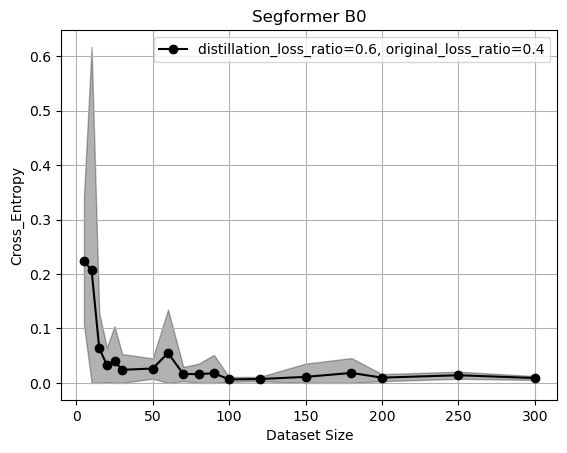

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()